In [2]:
from __future__ import print_function
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import poisson
from scipy.stats import expon

%matplotlib inline  

# Boils down to "If I pick hosts 2 * (rf - 1) * vnode times, how many
# distinct hosts will I have in expectation". Note that this is a slightly
# optimistic estimate because Cassandra won't place two replicas of the
# same token on the same machine or rack, but this is close enough for
# the model
# This is a variant of the Birthday Problem where we are interested
# in the number of distinct values produced
# http://www.randomservices.org/random/urn/Birthday.html
def num_neighbors(n, v, rf, strategy="rack"):
    k = 2 * v * (rf - 1)
    if strategy == "rack":
        # As cassandra is rack aware, we assume #racks == #replicas
        # This is maybe a bad assumption for some datacenter deployments
        n = n - (n // rf)
    else:
        # SimpleStrategy
        n = n - 1
    estimate = (n * (1.0 - (1.0 - 1.0/n) ** k))
    return max(rf - 1, min(estimate, n))

def p_outage_given_failure(recovery_seconds, num_neighbors, rate_in_seconds):
    x = math.exp(-1 * recovery_seconds * num_neighbors * rate_in_seconds)
    return 1 - x

def global_rate(node_rate, nodes, split_probability):
    return node_rate * nodes * split_probability

def recovery_seconds(size, bw_in, bw_out, neighbors, recovery='streaming'):
    if recovery == 'ebs':
        return 60 * 5
    return int(size / (min(bw_in, neighbors * bw_out)))
    

# Default model
nodes = 96
vnodes = 256
rf = 3
# 1000 gigabytes
node_dataset_mb = 300 * 1024
# MB/s
bw_in = 125
# MB/s, cassandra.yaml has 25MBPS as the default
# but most operators observe maybe half of that 
bw_out = 25 / 2
strategy = 'rack'

year_seconds = 60.0*60*24*365
century_seconds = 100 * year_seconds

# Model machines that fail on average 
# 25 times per century a.k.a 1 in 4 machines
# fails per year, or a machine fails every
# 4 years
arate = 25
arate_in_seconds = 25 / century_seconds


print("\nFailure Rate Variability")
print("Neighbors for {0} vnodes: {1:.3f}".format(1, num_neighbors(nodes, 1, rf)))
print("Neighbors for {0} vnodes: {1:.3f}".format(4, num_neighbors(nodes, 4, rf)))
print("Neighbors for {0} vnodes: {1:.3f}".format(16, num_neighbors(nodes, 16, rf)))

aneighbors = num_neighbors(nodes, vnodes, rf)
arecovery = recovery_seconds(node_dataset_mb, bw_in, bw_out, aneighbors)
print("Neighbors for {0} vnodes: {1:.3f}".format(vnodes, aneighbors))


def outage_stats(
        vnodes, failure_rate_per_century, num_nodes,
        rf, bw_in, bw_out,
        strategy='rack', recovery='streaming'):
    neighbors = num_neighbors(num_nodes, vnodes, rf, strategy)
    recovery_s = recovery_seconds(node_dataset_mb, bw_in, bw_out, neighbors, recovery)
    p_failure = p_outage_given_failure(
        recovery_s, neighbors, failure_rate_per_century / century_seconds)
    
    lmb = global_rate(failure_rate_per_century, num_nodes, p_failure)
    return (
        poisson.mean(lmb), poisson.interval(0.50, lmb), poisson.median(lmb),
        expon.mean(scale=1/lmb), expon.interval(0.50, scale=1/lmb)
    )

# Returns outages _per century_
def compute_outage(
        vnodes, failure_rate_per_century, num_nodes,
        rf, bw_in, bw_out,
        strategy='rack', recovery='streaming'):
    return outage_stats(
        vnodes, failure_rate_per_century, num_nodes, rf, bw_in, bw_out, strategy
    )[0]

print("{0:<6} {1:<8} {2:<8} {3:<8} -> {4:<6}".format(
    "rate", "rec_s", "p_fail", "g_lmb", "outages"
))
for rate in (12.5, 25, 50, 100, 200):
    recovery_s = recovery_seconds(node_dataset_mb, bw_in, bw_out, aneighbors)
    p_failure = p_outage_given_failure(
        recovery_s, aneighbors, rate / century_seconds)
    gl = global_rate(rate, nodes, p_failure)
    p = "{0:6.2f} {1:6.2f} {2:8.6f} {3:8.4f} -> {4:6.6f}".format(
        rate, recovery_s, p_failure, gl, poisson.mean(gl)
    )
    print(p)



Failure Rate Variability
Neighbors for 1 vnodes: 3.907
Neighbors for 4 vnodes: 14.255
Neighbors for 16 vnodes: 40.641
Neighbors for 256 vnodes: 64.000
rate   rec_s    p_fail   g_lmb    -> outages
 12.50 2457.00 0.000623   0.7477 -> 0.747712
 25.00 2457.00 0.001246   2.9899 -> 2.989917
 50.00 2457.00 0.002490  11.9522 -> 11.952217
100.00 2457.00 0.004974  47.7493 -> 47.749343
200.00 2457.00 0.009923 190.5224 -> 190.522373


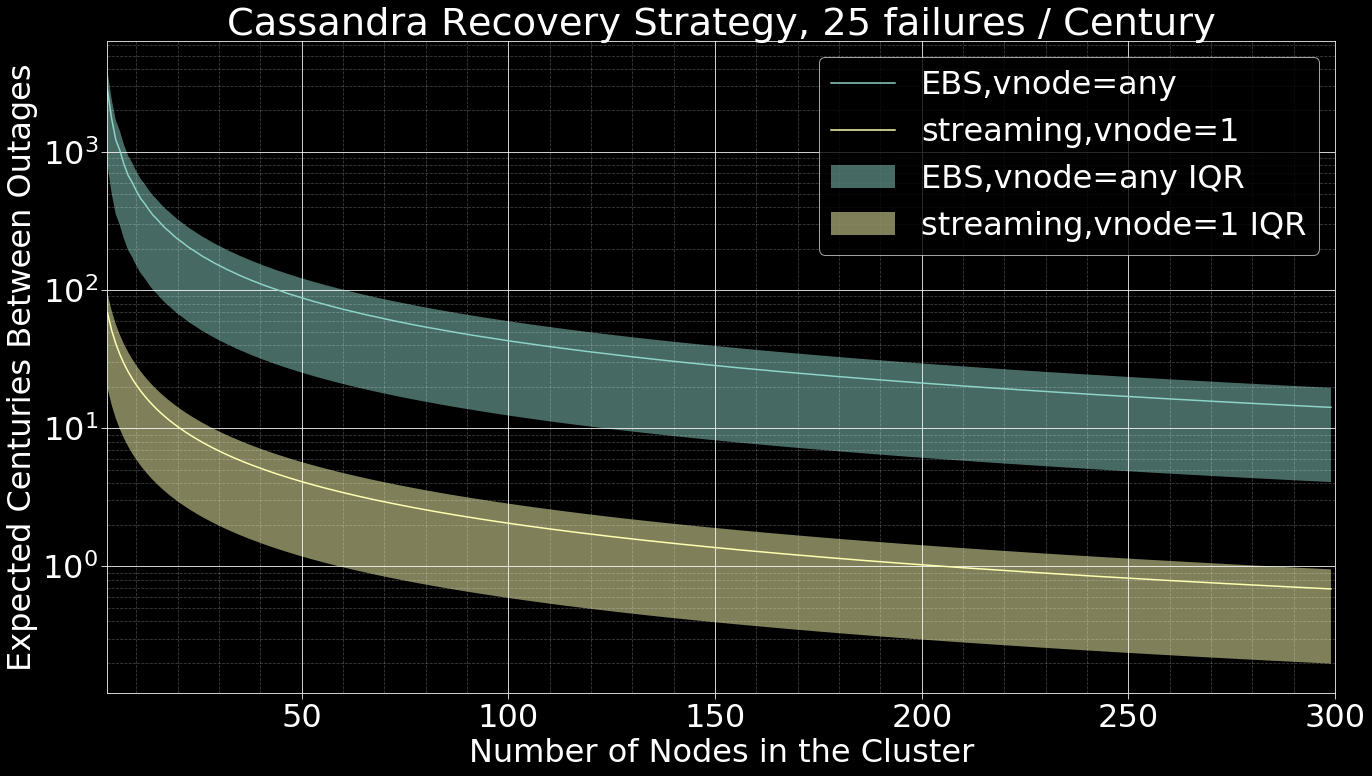

In [5]:
num_vnodes = range(1, 128)

outages = [outage_stats(v, arate, nodes, rf, bw_in, bw_out) for v in num_vnodes[:32]]
outage_mean = [o[0] for o in outages]
outage_lower = [o[1][0] for o in outages]
outage_upper = [o[1][1] for o in outages]
outage_median = [o[2] for o in outages]

# Observe impact of EBS on availability
plt.rcParams.update({'font.size': 32})
plt.style.use('dark_background')

fig = plt.figure(figsize=(22,12))
plt.title(
    "Cassandra Recovery Strategy, {0} failures / Century".format(arate))
plt.ylabel("Expected Centuries Between Outages")
plt.xlabel("Number of Nodes in the Cluster")
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.tick_params(axis='both', which='major', length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_nodes = range(3, 300)
lines = []

# Plot fixed recovery speed
outages = [outage_stats(1, arate, n, rf, bw_in, bw_out, recovery='ebs') for n in num_nodes]
outage_mean = [o[3] for o in outages]
outage_lower = [o[4][0] for o in outages]
outage_upper = [o[4][1] for o in outages]
line, = plt.semilogy(num_nodes, outage_mean, label="EBS,vnode=any")
lines.append(line)
plt.fill_between(
    num_nodes, outage_lower, outage_upper, alpha=0.5,
    label='EBS,vnode=any IQR'
)

outages = [outage_stats(1, arate, n, rf, bw_in, bw_out, recovery='recovery') for n in num_nodes]
outage_mean = [o[3] for o in outages]
outage_lower = [o[4][0] for o in outages]
outage_upper = [o[4][1] for o in outages]
line, = plt.semilogy(num_nodes, outage_mean, label="streaming,vnode=1")
lines.append(line)
plt.grid(b=True, which='minor', color='white', linestyle='--', alpha=0.25)
plt.grid(b=True, which='major', color='white', linestyle='-')
plt.fill_between(
    num_nodes, outage_lower, outage_upper, alpha=0.5,
    label='streaming,vnode=1 IQR'
)

plt.xlim(3, 300)

plt.legend()
plt.show()
fig.savefig('ebs_recovery.png', transparent=True)